# Togo Active Learning Experiment Runner

This notebook manages the execution of sampling experiments on the Togo soil fertility dataset.

Author: Livia Betti  
Date: July 2025

### To run this notebook, the following tasks should be completed:
1. Generate relevant groups in Togo. I have generated group assignments based on regions, but if there are other representative groups that might be useful, we can generate those as well.
2. Assign (distance-based) costs for the Convenience sampling setting

## Imports

In [ ]:
%pip install simplejson
%pip install yacs

In [ ]:
%pip install numpy
%pip install dill
%pip install pandas
%pip install geopandas
%pip install matplotlib
%pip install rasterio

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install torchgeo==0.6.2

In [5]:
import sys
import os

In [6]:
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

add_path(os.path.abspath('..'))

In [7]:
import dill
from pathlib import Path
from copy import deepcopy

from pycls.core.config import cfg, dump_cfg
from train import main
from pycls.datasets.data import Data


In [8]:
base_dir = Path("/Users/liviabetti/Desktop/togo_experiments/sampling") #replace with path to folder
cfg_file = base_dir / "configs" / "togo" / "RIDGE.yaml"  #adjust if needed

## Core config values

In [ ]:
cfg.DATASET.NAME = "TOGO"

#Change below to match your setup
cfg.DATASET.ROOT_DIR = "/Users/liviabetti/Desktop/togo_experiments/"
cfg.DATASET.RESAMPLED_CSV = "togo_soil_fertility_resampled.csv"
cfg.DATASET.FEATURE_FILE = "/Users/liviabetti/Desktop/togo_experiments/planet_medres_normalized_analytic_2020-09_mosaic_features.feather"
cfg.DATASET.IS_FEATHER = True

cfg.DATASET.ROOT_DIR = os.path.abspath(cfg.DATASET.ROOT_DIR)

In [9]:
#static experiment parameters
seeds = [1, 42, 123, 456, 789, 1234, 5678, 9101, 1213, 1415]
methods = ["random", "greedycost", "poprisk", "similarity"]
budgets = [100, 500, 1000, 5000, 10000]

# Common
init_name = "empty_initial_set"
dataset = "togo"
group_type = "regions"
util_lambda = 0.5
group_assignment_path = "/Users/liviabetti/Desktop/togo_experiments/admins/region_assignment.pkl"


In [10]:
def load_assignment(path, ids):
    with open(path, "rb") as f:
        loaded = dill.load(f)

    if isinstance(loaded, dict):
        mapping = loaded
    elif 'ids' in loaded:
        mapping = dict(zip(loaded['ids'], loaded['assignments']))
    else:
        mapping = dict(zip(ids, loaded['assignments']))

    return [str(mapping[i]) for i in ids]

## Load and Prepare Config

In [11]:
cfg.merge_from_file(cfg_file)
cfg.DATASET.ROOT_DIR = os.path.abspath(cfg.DATASET.ROOT_DIR)

## Cost related arguments

In [12]:
# === Experiment Grid ===

cost_fns = ["uniform", "convenience_based"]
methods = ["random", "greedycost", "poprisk"]

cost_array_path = "../../costs/distance_based_costs_top1_urban.pkl"

In [ ]:
similarity_matrix_path = "../../cosine_similarity_togo.npz"

[RUNNING] togo_empty_initial_set_cost_uniform_method_random_budget_100_seed_1
🗑️  Removing previous log file: /Users/liviabetti/Desktop/togo_experiments/output/TOGO/empty_initial_set/uniform/random/budget_100/seed_1/stdout.log
Sampling initial pool from IDS
Running uniform cost random selection
Sampled 100 points!
Plotting latlon subset...
Plotting latlon subset...
[RUNNING] togo_empty_initial_set_cost_uniform_method_random_budget_500_seed_1
🗑️  Removing previous log file: /Users/liviabetti/Desktop/togo_experiments/output/TOGO/empty_initial_set/uniform/random/budget_500/seed_1/stdout.log


KeyboardInterrupt: 

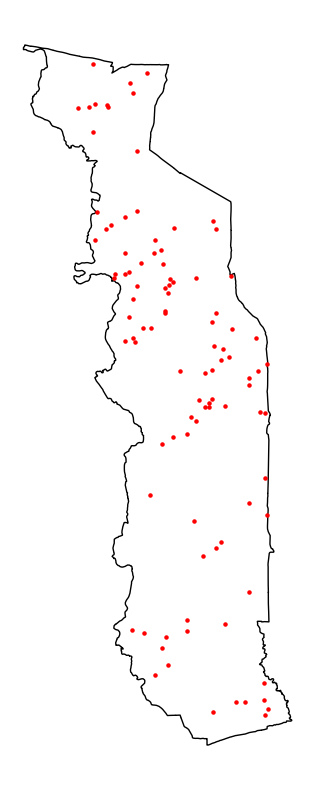

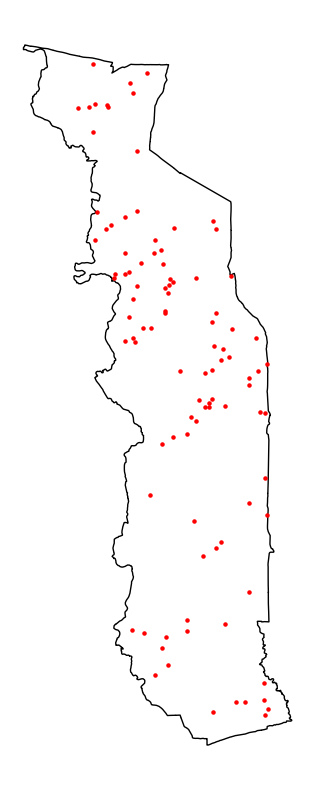

In [ ]:
for seed in seeds:
    for cost_fn in cost_fns:
        base_cfg = deepcopy(cfg)
        base_cfg.RNG_SEED = seed
        base_cfg.INITIAL_SET.STR = init_name

        #load dataset early to get train_data.ids for cost and group loading
        data_obj = Data(base_cfg)
        train_data, _ = data_obj.getDataset(isTrain=True)

        #set cost function config
        if cost_fn == "convenience_based":
            base_cfg.COST.FN = "pointwise_by_array"
            base_cfg.COST.NAME = "convenience_based"

            cost_path = cost_array_path
            with open(cost_path, "rb") as f:
                loaded = dill.load(f)
            if 'ids' in loaded:
                idx_to_cost = dict(zip(loaded['ids'], loaded['costs']))
            else:
                idx_to_cost = dict(zip(train_data.ids, loaded['assignments']))

            base_cfg.COST.ARRAY = [float(idx_to_cost[i]) for i in train_data.ids]

        else:
            base_cfg.COST.FN = "uniform"
            base_cfg.COST.NAME = "uniform"
            base_cfg.COST.ARRAY = []

        base_cfg.GROUPS.GROUP_TYPE = group_type
        base_cfg.GROUPS.GROUP_ASSIGNMENT = load_assignment(group_assignment_path, train_data.ids)


        for method in methods:
            for budget in budgets:
                this_cfg = deepcopy(base_cfg)
                this_cfg.ACTIVE_LEARNING.SAMPLING_FN = method
                this_cfg.ACTIVE_LEARNING.BUDGET_SIZE = budget
                this_cfg.ACTIVE_LEARNING.UTIL_LAMBDA = util_lambda
                this_cfg.ACTIVE_LEARNING.SIMILARITY_MATRIX_PATH = similarity_matrix_path
                this_cfg.ACTIVE_LEARNING.OPT = method in ["greedycost", "poprisk", "similarity", "diversity"]


                exp_name = f"{dataset}_{init_name}_cost_{cost_fn}_method_{method}"
                if method == "poprisk":
                    exp_name += f"_{group_type}"
                exp_name += f"_budget_{budget}_seed_{seed}"
                this_cfg.EXP_NAME = exp_name

                print(f"[RUNNING] {exp_name}")
                dump_cfg(cfg)
                main(this_cfg)